#Group 14 Project 1 FINAL
##Below is the submission for: Myer Khan, Anika Vemuri, Henrietta Namale, Maria Ninan, & Neha Sonthi

**Bits and Information**
Bits are a unit of measure to predict the amount of uncertainty of a model. Bits essentially quantify the amount of information that is necessary. Higher number of bits is often indicative of more information needed, which in turn suggests higher uncertainty and higher entropy.  

**Description of I&F Model:**
It represents a simplified way to simulate neuronal spiking behavior, implying that membrane potential increases linearly and injected current does not decay over time.
The IF model does not include leaky ion channels, which are important in the LIF model and real biological neurons. As a result, this model shows a hard drop back to resting potential instead of a gradual decline that should be present because of the leaky channels. This model does show how positive currents bring it closer to threshold which aligns with a real biological neuron. However, in order to account for how an action potential is generated in the AIS in a biological neuron, this model includes a spike generator that responds once the voltage reaches threshold, rather than the presence of voltage-gated ion channels in a real biological neuron to generate an action potential. The LIF model incorporates leaky ion channels to represent the gradual decline of membrane potential like that of a biological neuron. However, this model is missing the voltage-gated ion channels in real biological neurons and requires an artificial spike generator to generate action potentials once threshold is reached.

Matplotlib is building the font cache; this may take a moment.


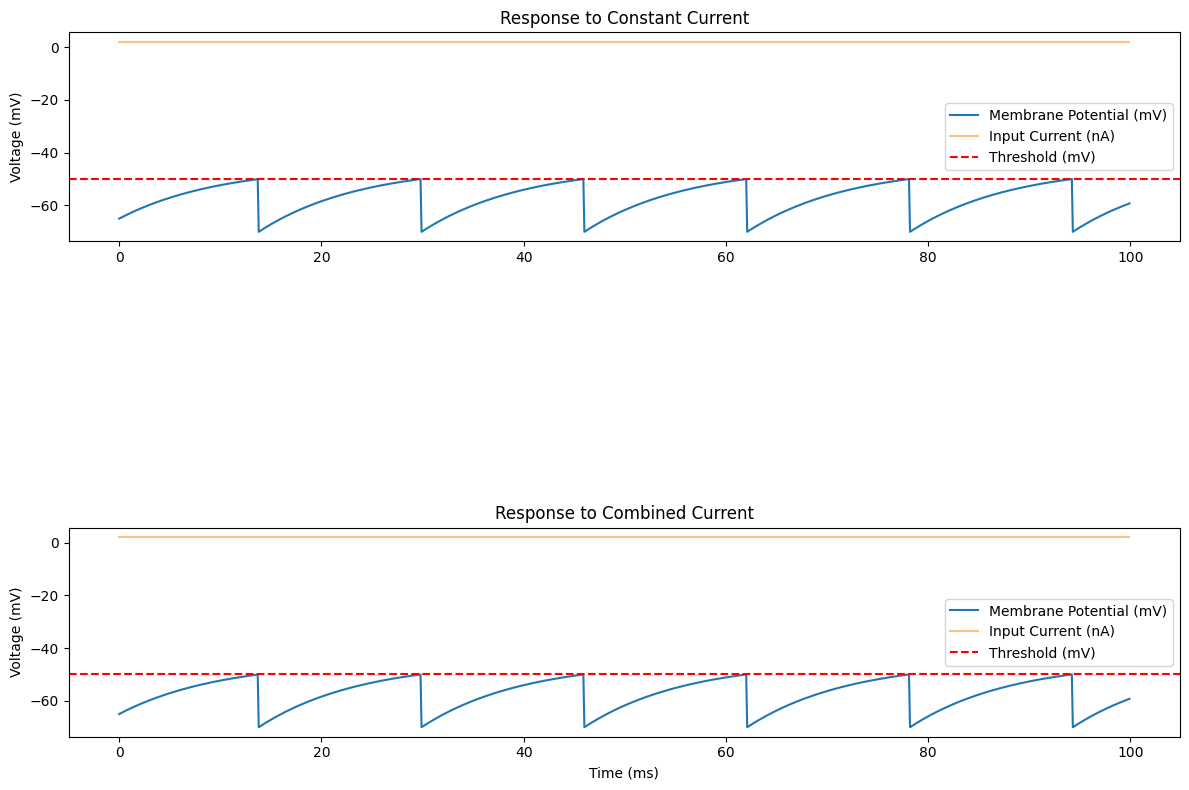

Spike analysis for constant current: {'spike_count': 6, 'mean_isi': np.float64(16.1), 'std_isi': np.float64(3.552713678800501e-15)}
Spike analysis for combined current: {'spike_count': 6, 'mean_isi': np.float64(16.1), 'std_isi': np.float64(3.552713678800501e-15)}


In [1]:
#I&F Model
import numpy as np
import matplotlib.pyplot as plt

# Define simulation parameters
dt = 0.1  # Time step (ms)
t = np.arange(0, 100, dt)  # Simulation time (ms)

# Define neuron parameters
V_rest = -65  # Resting membrane potential (mV)
V_th = -50  # Threshold potential (mV)
V_reset = -70  # Reset potential (mV)
R_m = 10  # Membrane resistance (MΩ)
tau_m = 10  # Membrane time constant (ms)

# Define input currents (can be modified to explore different patterns)
def constant_current(I):
    return np.ones(len(t)) * I

# Function to simulate IF neuron
def simulate_IF(I):
    V = np.zeros(len(t))  # Membrane potential over time
    V[0] = V_rest
    spikes = []  # Spike times

    for i in range(1, len(t)):
        dV = (-(V[i-1] - V_rest) + R_m * I[i]) / tau_m
        V[i] = V[i-1] + dV * dt

        if V[i] >= V_th:  # Spike condition
            V[i] = V_reset
            spikes.append(t[i])

    return V, spikes

# Visualize the response to different currents
plt.figure(figsize=(12, 8))

# Constant input current
I_const = constant_current(2)  # 2 nA current
V_const, spikes_const = simulate_IF(I_const)
plt.subplot(3, 1, 1)
plt.plot(t, V_const, label="Membrane Potential (mV)")
plt.plot(t, I_const, label="Input Current (nA)", alpha=0.5)
plt.axhline(V_th, color='r', linestyle='--', label="Threshold (mV)")
plt.title("Response to Constant Current")
plt.ylabel("Voltage (mV)")
plt.legend()

# Combined input current
I_combined = I_const 
V_combined, spikes_combined = simulate_IF(I_combined)
plt.subplot(3, 1, 3)
plt.plot(t, V_combined, label="Membrane Potential (mV)")
plt.plot(t, I_combined, label="Input Current (nA)", alpha=0.5)
plt.axhline(V_th, color='r', linestyle='--', label="Threshold (mV)")
plt.title("Response to Combined Current")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.legend()

plt.tight_layout()
plt.show()

# Spike analysis
def analyze_spikes(spikes):
    isi = np.diff(spikes)  # Interspike intervals
    return {
        "spike_count": len(spikes),
        "mean_isi": np.mean(isi) if len(isi) > 0 else None,
        "std_isi": np.std(isi) if len(isi) > 0 else None
    }

print("Spike analysis for constant current:", analyze_spikes(spikes_const))
print("Spike analysis for combined current:", analyze_spikes(spikes_combined))


**Description of HH Model:**
The HH Model extends on the LIF model by including both voltage-gated sodium and voltage-gated potassium channels, which makes the overall model more realistic and sophisticated. In this model, the previous spike generator limitation is met by the inclusion of the voltage-gated channels. One limitation is that this model assumes that all parts of the neuron have the same properties and that all the ion channels behave in the same manner.

The HH model contains more bits than the LIF and I&F models since the HH model is more complex and requires more information to be modeled, as it also includes information about voltage-gated channels (which is lacking in the LIF and I&F models). Thus, it is expected that the HH model would have the highest Shannon’s entropy, as it is the model that is most complex, has more bits, and requires the most amount of information which would suggest higher uncertainty. The HH model also includes voltage-gated ion channels that enable the model to include the nuance of summation/graded potentials and thus enables more states like what we see with the sub threshold potential line. 

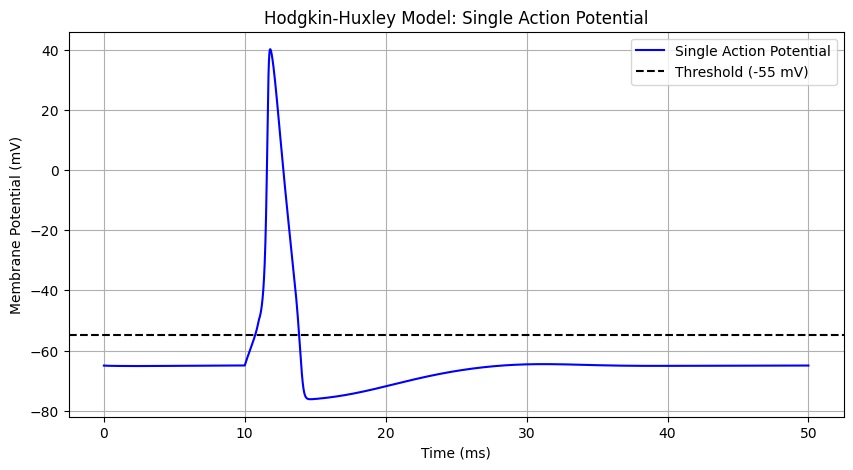

In [2]:
#HH Model
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define HH model parameters
C_m = 1.0  # Membrane capacitance (uF/cm^2)
g_Na = 120.0  # Maximum sodium conductance (mS/cm^2)
g_K = 36.0  # Maximum potassium conductance (mS/cm^2)
g_L = 0.3  # Leak conductance (mS/cm^2)
E_Na = 50.0  # Sodium reversal potential (mV)
E_K = -77.0  # Potassium reversal potential (mV)
E_L = -54.4  # Leak reversal potential (mV)

# Functions for gating variables
def alpha_n(V): return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
def beta_n(V): return 0.125 * np.exp(-(V + 65) / 80)
def alpha_m(V): return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
def beta_m(V): return 4.0 * np.exp(-(V + 65) / 18)
def alpha_h(V): return 0.07 * np.exp(-(V + 65) / 20)
def beta_h(V): return 1 / (1 + np.exp(-(V + 35) / 10))

# HH equations for time-dependent input
def HH(y, t, I_t, t_values):
    V, m, h, n = y
    I = np.interp(t, t_values, I_t)  # Interpolate current

    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n

    I_Na = g_Na * (m ** 3) * h * (V - E_Na)
    I_K = g_K * (n ** 4) * (V - E_K)
    I_L = g_L * (V - E_L)

    dVdt = (I - (I_Na + I_K + I_L)) / C_m
    return [dVdt, dmdt, dhdt, dndt]

# Time vector
t = np.linspace(0, 50, 5000)  # 50 ms simulation

# Define single pulse input current
I_single_spike = np.zeros_like(t)  
I_single_spike[1000:1100] = 15  # Stronger pulse (15 µA/cm² for 2 ms)

# Initial conditions
y0 = [-65, 0.05, 0.6, 0.32]  # Initial V, m, h, n

# Solve HH equations for single action potential
sol_single_spike = odeint(HH, y0, t, args=(I_single_spike, t))

# Plot results
plt.figure(figsize=(10, 5))

# Single action potential plot
plt.plot(t, sol_single_spike[:, 0], label="Single Action Potential", color="blue")

# Threshold line
plt.axhline(-55, linestyle="--", color="black", label="Threshold (-55 mV)")

# Labels and legend
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.title("Hodgkin-Huxley Model: Single Action Potential")
plt.legend()
plt.grid()

plt.show()

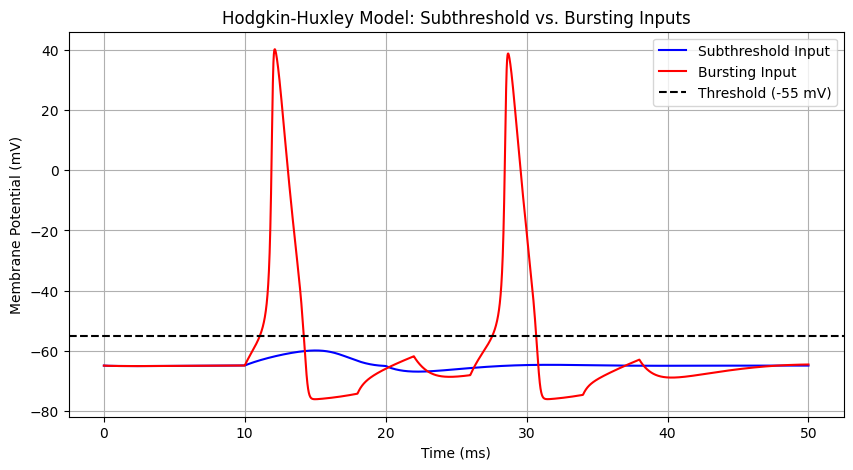

In [3]:
#HH Model with varying inputs
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define HH model parameters
C_m = 1.0  # Membrane capacitance (uF/cm^2)
g_Na = 120.0  # Maximum sodium conductance (mS/cm^2)
g_K = 36.0  # Maximum potassium conductance (mS/cm^2)
g_L = 0.3  # Leak conductance (mS/cm^2)
E_Na = 50.0  # Sodium reversal potential (mV)
E_K = -77.0  # Potassium reversal potential (mV)
E_L = -54.4  # Leak reversal potential (mV)

# Functions for gating variables
def alpha_n(V): return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
def beta_n(V): return 0.125 * np.exp(-(V + 65) / 80)
def alpha_m(V): return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
def beta_m(V): return 4.0 * np.exp(-(V + 65) / 18)
def alpha_h(V): return 0.07 * np.exp(-(V + 65) / 20)
def beta_h(V): return 1 / (1 + np.exp(-(V + 35) / 10))

# Hodgkin-Huxley model with time-dependent input
def HH(y, t, I_t, t_values):
    V, m, h, n = y
    
    # Interpolate current value based on time
    I = np.interp(t, t_values, I_t)
    
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n

    I_Na = g_Na * (m ** 3) * h * (V - E_Na)
    I_K = g_K * (n ** 4) * (V - E_K)
    I_L = g_L * (V - E_L)

    dVdt = (I - (I_Na + I_K + I_L)) / C_m

    return [dVdt, dmdt, dhdt, dndt]

# Time vector
t = np.linspace(0, 50, 5000)  # 50 ms simulation

# Define subthreshold current (below firing threshold)
I_subthreshold = np.zeros_like(t)  
I_subthreshold[1000:2000] = 2  # Weak input (subthreshold)

# Define bursting input current
I_burst = np.zeros_like(t)
for i in range(1000, 4000, 800):  # Periodic bursts
    I_burst[i:i+400] = 10  # Strong input to induce bursts

# Initial conditions
y0 = [-65, 0.05, 0.6, 0.32]  # Initial V, m, h, n

# Solve HH equations for both inputs
sol_subthreshold = odeint(HH, y0, t, args=(I_subthreshold, t))
sol_burst = odeint(HH, y0, t, args=(I_burst, t))

# Plot results
plt.figure(figsize=(10, 5))

# Subthreshold plot
plt.plot(t, sol_subthreshold[:, 0], label="Subthreshold Input", color="blue")

# Bursting plot
plt.plot(t, sol_burst[:, 0], label="Bursting Input", color="red")

# Threshold line
plt.axhline(-55, linestyle="--", color="black", label="Threshold (-55 mV)")

# Labels and legend
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.title("Hodgkin-Huxley Model: Subthreshold vs. Bursting Inputs")
plt.legend()
plt.grid()

plt.show()

_Changes to updtate the original HH model to achieve the one above_
1.  add a subthreshold input that did not reach action potential because the first graph it give had a spike with the subthreshold line
2. added bursting outputs to the graph

_How ChatGBT added the updates with our prompts_
1. Chat GBT reduced the current amplitude of the subthreshold line to 2 from 5, so the updated code was "I_subthreshold[1000:2000] = 2".
2. Chat GBT added the following to include inputs coming in bursts
   "# Define bursting input current
I_burst = np.zeros_like(t)
for i in range(1000, 4000, 800):  # Periodic bursts
    I_burst[i:i+400] = 10  # Strong input to induce bursts"

By decreasing the currents, there was less of a depolarizing effect on the neuron that resulted in a subthreshold input that did not reach threshold and fire an action potential (shown in blue line). On the other hand, when the current amplitude was increased to 10 to have a stronger amplitude, the result was a bursting pattern as shown in red. 

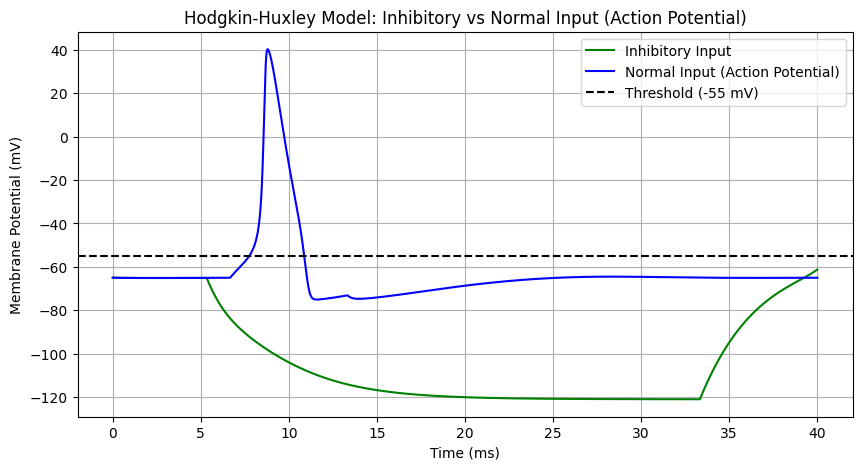

In [4]:
#HH Model with Inhibitory Input
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define HH model parameters
C_m = 1.0  # Membrane capacitance (uF/cm^2)
g_Na = 120.0  # Maximum sodium conductance (mS/cm^2)
g_K = 36.0  # Maximum potassium conductance (mS/cm^2)
g_L = 0.3  # Leak conductance (mS/cm^2)
E_Na = 50.0  # Sodium reversal potential (mV)
E_K = -77.0  # Potassium reversal potential (mV)
E_L = -54.4  # Leak reversal potential (mV)

# Functions for gating variables
def alpha_n(V): return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
def beta_n(V): return 0.125 * np.exp(-(V + 65) / 80)
def alpha_m(V): return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
def beta_m(V): return 4.0 * np.exp(-(V + 65) / 18)
def alpha_h(V): return 0.07 * np.exp(-(V + 65) / 20)
def beta_h(V): return 1 / (1 + np.exp(-(V + 35) / 10))

# Hodgkin-Huxley model with time-dependent input
def HH(y, t, I_t, t_values):
    V, m, h, n = y
    
    # Interpolate current value based on time
    I = np.interp(t, t_values, I_t)
    
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n

    I_Na = g_Na * (m ** 3) * h * (V - E_Na)
    I_K = g_K * (n ** 4) * (V - E_K)
    I_L = g_L * (V - E_L)

    dVdt = (I - (I_Na + I_K + I_L)) / C_m

    return [dVdt, dmdt, dhdt, dndt]

# Time vector (40 ms simulation for inhibitory input)
t = np.linspace(0, 40, 6000)  # 40 ms simulation

# Define inhibitory input (strong enough to prevent firing)
I_inhibitory = np.zeros_like(t)
I_inhibitory[800:5000] = -20  # Inhibitory input lasting for 60 ms

# Define normal input that will trigger an action potential
I_normal = np.zeros_like(t)
I_normal[1000:2000] = 10  # Strong input to induce action potential

# Initial conditions
y0 = [-65, 0.05, 0.6, 0.32]  # Initial V, m, h, n

# Solve HH equations for inhibitory and normal inputs
sol_inhibitory = odeint(HH, y0, t, args=(I_inhibitory, t))
sol_normal = odeint(HH, y0, t, args=(I_normal, t))

# Plot results
plt.figure(figsize=(10, 5))

# Inhibitory input plot
plt.plot(t, sol_inhibitory[:, 0], label="Inhibitory Input", color="green")

# Normal input plot (action potential)
plt.plot(t, sol_normal[:, 0], label="Normal Input (Action Potential)", color="blue")

# Threshold line
plt.axhline(-55, linestyle="--", color="black", label="Threshold (-55 mV)")

# Labels and legend
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.title("Hodgkin-Huxley Model: Inhibitory vs Normal Input (Action Potential)")
plt.legend()
plt.grid()

plt.show()

_Changes that were made to the original HH model to add inhibitory input_

We added I_inhibitory to our code for a duration of time by adding the following lines of code:
# Define inhibitory input (strong enough to prevent firing)
I_inhibitory = np.zeros_like(t)
I_inhibitory[800:5000] = -20  # Inhibitory input lasting for 30 ms

When an inhibitory input was added, the result was hyperpolarization that prevented the membrane potential from reaching threshold and firing an action potential (as shown in green). The inhibitory input caused a strong negative current that resulted in the green curve as opposed to the normal input line shown in blue. 

**Description of Simple Neural Network - Feedforward Model:**

A type of artificial neural network that moves information in one direction, from input to output and does not contain cycles or feedback loops. It is used commonly in multi layer perceptrons and the input layer is able to receive raw data, processed layer by layer, whilst the output layer works on the production.If the model contains any hidden layers, it works to process this information and activate functions. The benefits are that it is easy and efficient to use as well as easy to interpret in classification and regression tasks. Some limitations are that it is unsuitable for sequential data, needs hidden layers to overcome complex patterns, and struggles to adapt to past outputs. While this ANN model is the most complex and has the most information capacity out of all three models, it is the least biologically relevant. Since the feedforward model is more complex compared to the IF and HH model, it would contain the most bits. The IF model doesn't show neuronal processes in as much detail as the other models, and the simple neural network has the ability to process larger sets of data and has learning abilities, unlike the HH model and I&F model. 

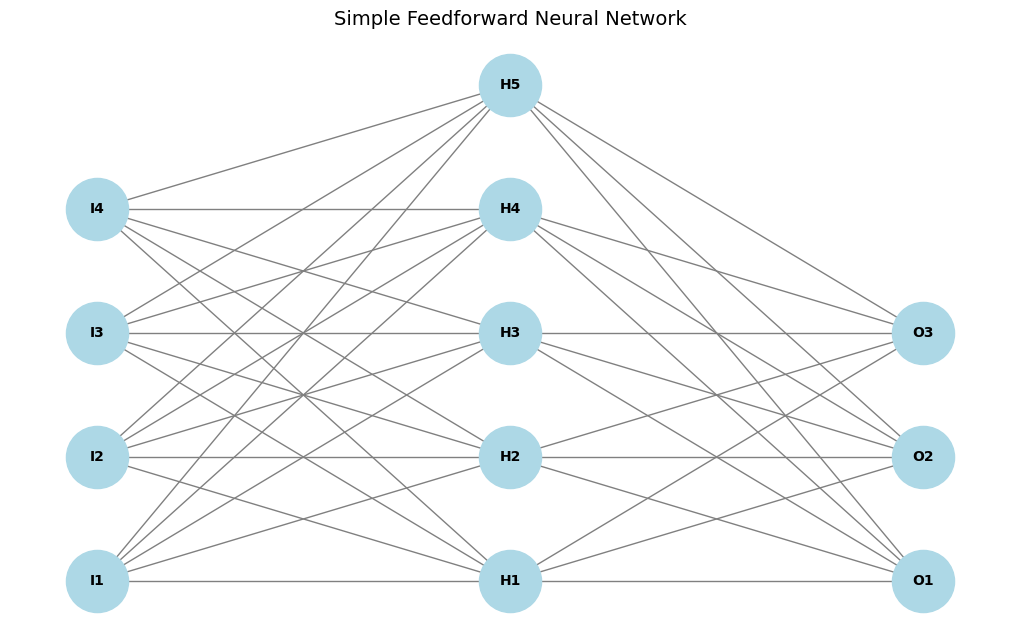

In [5]:
#Feedforward Model
import matplotlib.pyplot as plt
import networkx as nx

def plot_neural_network():
    # Create a new graph
    G = nx.Graph()

    # Number of neurons in each layer (for simplicity, we will use 3 layers)
    input_layer = 4  # 4 neurons in the input layer
    hidden_layer = 5  # 5 neurons in the hidden layer
    output_layer = 3  # 3 neurons in the output layer

    # Add nodes for each layer
    for i in range(input_layer):
        G.add_node(f'I{i+1}', layer=0, pos=(0, i))
    for i in range(hidden_layer):
        G.add_node(f'H{i+1}', layer=1, pos=(1, i))
    for i in range(output_layer):
        G.add_node(f'O{i+1}', layer=2, pos=(2, i))

    # Add edges between layers (fully connected network)
    for i in range(input_layer):
        for j in range(hidden_layer):
            G.add_edge(f'I{i+1}', f'H{j+1}')
    for i in range(hidden_layer):
        for j in range(output_layer):
            G.add_edge(f'H{i+1}', f'O{j+1}')

    # Set up positions for each node (layer-based position)
    pos = nx.get_node_attributes(G, 'pos')

    # Draw the graph
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')

    # Display the plot
    plt.title("Simple Feedforward Neural Network", fontsize=14)
    plt.show()

# Call the function to plot the network
plot_neural_network()

**Coincidence Detection for Sound** 

Neurons act as coincidence detectors in the auditory system of many birds and mammals to help organisms localize the source of sounds relative to their body position. Barn owls are a great example of an organism that relies on the use of this coincidence detection system to determine the location of mice, especially amid their dark surroundings ( [Macrocircuits for sound localization use leaky coincidence detectors and specialized synapse](https://pmc.ncbi.nlm.nih.gov/articles/PMC3755899/).) For this to work, a sound travels to both ears and is transmitted along neural pathways called delay lines from both ears. The neurons receive the sound inputs from the delay lines from both ears; however, the neurons are only able to fire if they receive inputs simultaneously from both ears’ delay lines. Interaural Time Difference (ITD) is a measure of the difference between the firing rate of the two ears.

The position of the sound source can affect the firing patterns of the neurons. For example, consider a sound that is emitted equidistant to both the left and right ear. Based on the concept of coincidence detection, the sound will arrive at each ear in the same amount of time (let us say 2 ms). From there, the sound detected by the right ear will move along the delay line toward the left, and the sound detected by the left ear will move along the delay line toward the right. Neurons 1 and 5 will be excited first, but neither will reach threshold and fire since simultaneous input from both ears is not received. After, Neurons 2 and 4 will be excited, but once again will not reach threshold and fire since simultaneous input from both ears is not received. Finally, Neuron 3 will receive simultaneous input from both the left and right ear, and will thus reach threshold and fire an action potential. Since Neuron 3 fires in the middle, we can assume that the sound is at an equal distance away from both ears, and therefore the ITD is 0.

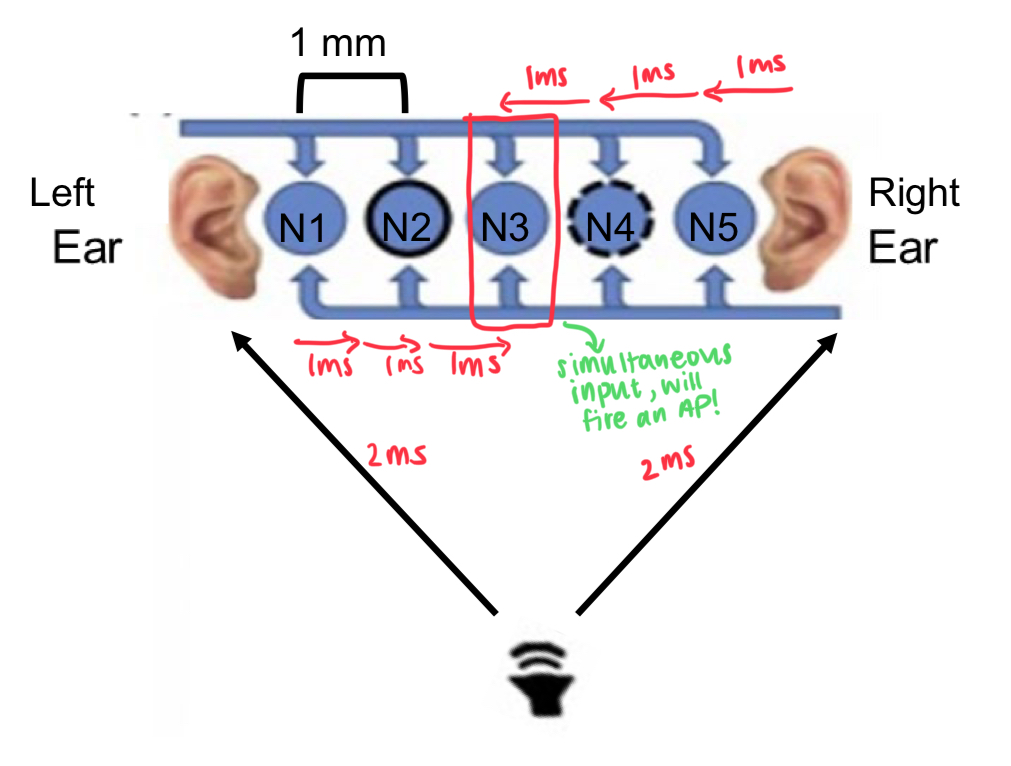

In contrast, the movement of sound to be positioned closer to one ear compared to the other ear can change the firing pattern of the neurons. For example, consider a sound that is positioned closer to the right ear that the left ear. When sound is emitted, it will take less time and distance for the sound to reach the right ear, and more time and distance for the sound to reach the left ear. If it takes 1 ms for the sound to arrive at the right ear, at each subsequent ms the sound will travel down the delay line towards the left to excite neurons (N5 -> N4 -> N3); however, these neurons will not reach threshold and fire since simultaneous input from both ears is not received. If it takes 3 ms for the sound to arrive at the left ear, then after the subsequent ms, Neuron 2 will receive simultaneous input from both delay lines to reach threshold and generate an action potential. In this case, the sound along the delay line of the right ear travels at 5 mm/ms to reach Neuron 2, while the sound along the delay line of the left ear travels at 2 mm/ms to reach Neuron 2, indicating that the ITD is 5 mm/ms - 2 mm/ms = 3 mm/ms.

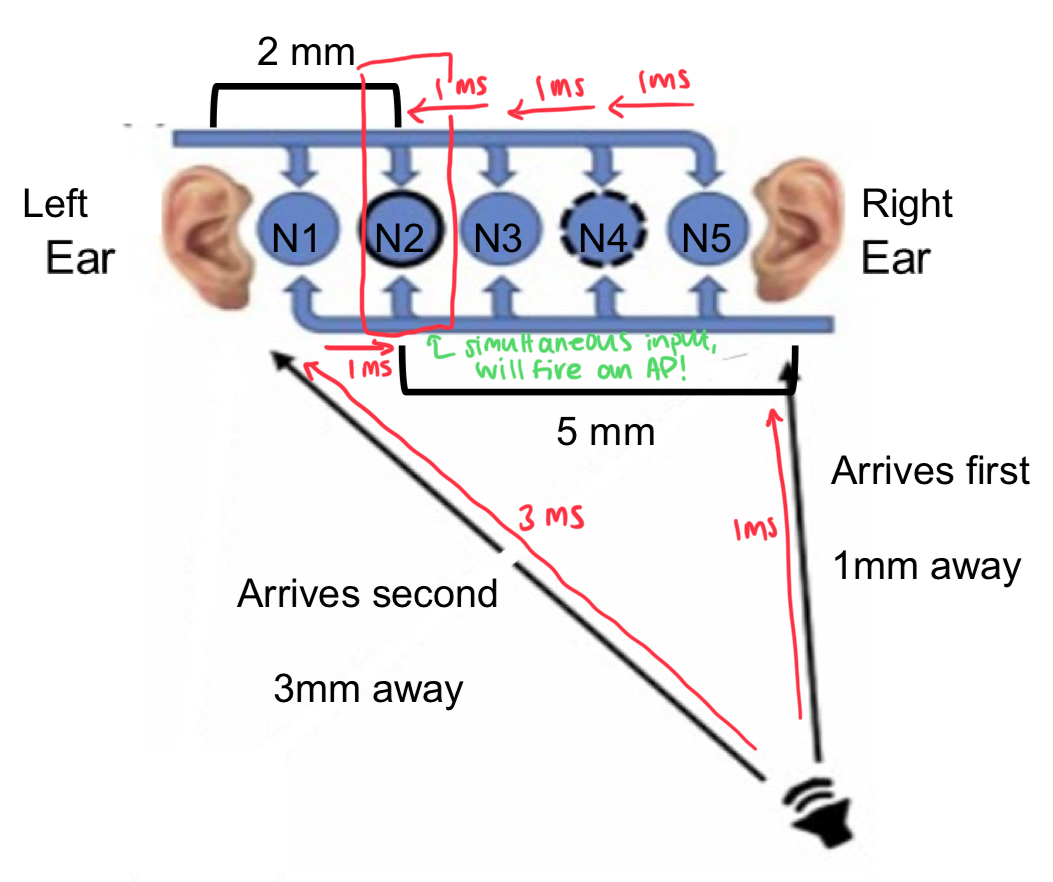
 
It is important to keep in mind that both ears must hear the sound in order for neurons to fire and generate an action potential. If only the left ear is able to hear the sound and not the right ear, then there will not be simultaneous delivery of inputs from both ears and the neuron will not be able to reach threshold to fire.

This system of coincidence detection in the mammalian auditory system is known to play a role in a region known as the Medial Superior Olive (MSO), but little is known about the role of coincidence detection in the biaural neurons of the Lateral Superior Olive (LSO). However, studies have shown that LSO neurons receive both excitatory and inhibitory inputs which vary their output spike rates based on interaural time differences ( [Roles for Coincidence Detection in Coding Amplitude-Modulated Sounds](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004997).)